# Final Project

### Data Cleanup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import reduce
from stemming.porter2 import stem # this stemming library is used becuase it can work in list comprehension

In [2]:
## data set downloaded from
data = pd.read_csv('data/billboard-1964-2015-songs-lyrics.zip',encoding = "ISO-8859-1",skipinitialspace=True)
# try reading all data sets
#display(data.head())
print('Shape of data: ', data.shape)
# drop irrelevant columns
data = data.drop(columns=['Rank', 'Source'])
display(data.head())
print("Final data shape: ",data.shape)
print(data.dtypes)

Shape of data:  (5100, 6)


,Song,Artist,Year,Lyrics
0,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...
1,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...
2,i cant get no satisfaction,the rolling stones,1965,
3,you were on my mind,we five,1965,when i woke up this morning you were on my mi...
4,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...


Final data shape:  (5100, 4)
Song      object
Artist    object
Year       int64
Lyrics    object
dtype: object


In [3]:
# strip leading and trailing white space or new line characters
data = data.replace({r'^\s+': '',r'\s+$':'',r'\n':''}, regex=True)
# replace empty string with NaN
data = data.replace({'': np.nan})
data.head()


,Song,Artist,Year,Lyrics
0,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...
1,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...
2,i cant get no satisfaction,the rolling stones,1965,NaN
3,you were on my mind,we five,1965,when i woke up this morning you were on my min...
4,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss ...


In [4]:
# drop NA values
data.Lyrics[2]
data = data.dropna()
print('Shape after dropping NA: ',data.shape )
display(data.head())

Shape after dropping NA:  (4866, 4)


,Song,Artist,Year,Lyrics
0,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...
1,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...
3,you were on my mind,we five,1965,when i woke up this morning you were on my min...
4,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss ...
5,downtown,petula clark,1965,when youre alone and life is making you lonely...


In [5]:
#sanity check year seems fine no erronous data
year = data['Year'].unique()
year

array([1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

In [6]:
# lower string
data.Lyrics = data.Lyrics.str.lower()
data.head()

,Song,Artist,Year,Lyrics
0,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...
1,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...
3,you were on my mind,we five,1965,when i woke up this morning you were on my min...
4,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss ...
5,downtown,petula clark,1965,when youre alone and life is making you lonely...


## Parameters for word count

In [7]:
# variables needed for word cleanup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
print('Initially there are: ',len(stopwords),' stopwords')
# word choice based on initial analysis of old dataset. 
# futhrer choices informed by http://cs.brown.edu/courses/cs100/students/project11/
stopwords+= ['verse','chorus','im','dont','oh','got','get','yeah','you','youre','let','ill','gonna','aint','ive','youll']
print('there are ',len(stopwords),'stopwords')

Initially there are:  179  stopwords
there are  195 stopwords


[nltk_data] Downloading package stopwords to C:\Users\Jing
[nltk_data]     Yun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Meauring word repitition in individual songs
we would like to evaluate how repititive a song is like Gucci Gang or Daft Punk's all around the world. We want to evaluate how "diverse" a song is. Does the artist only use a few words to compose a long song like in Gucci Gang or Daft Punk's All AROund the World? <br/> <br/>

We thus come up with a measure of this called variance. we will measure the number of unique words the author uses in his song. To avoid stop words artificially inflating their score we will remove stop words. Procedure is as follow:
1. Remove stop words
2. calculate number of unique words
3. calculate song length
$$\text{variance}=\frac{\text{Number of unique words}}{\text{Number of words in song lyrics}}$$
The lower the variance score, the more repitive the song
<br/>

we would also like to avoid the artist using derivative of words (eg. general --> generalized) to boost their variance score therefore we also have a score called variance root 
1. Remove stop words
2. convert all words to thier root words
2. calculate number of unique root words
3. calculate song length
$$\text{variance-root}=\frac{\text{Number of unique root words}}{\text{Number of words in song lyrics}}$$
Conversion to root word is done using the [stemming function](https://pypi.org/project/stemming/)

In [8]:

# remove stop words
data['Filtered Lyrics']=data['Lyrics'].apply(lambda x:[word for word in x.split() if word not in stopwords])
# calculate variance 
data['Variance'] = data['Filtered Lyrics'].apply(lambda x: np.unique(np.array(x)).shape[0]/len(x))
# change all words to root word
data['Variance Root'] = data['Filtered Lyrics'].apply(lambda x:[stem(word) for word in x])
display(data.head())

,Song,Artist,Year,Lyrics,Filtered Lyrics,Variance,Variance Root
0,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"[sam, sham, miscellaneous, wooly, bully, wooly...",0.500000,"[sam, sham, miscellan, wooli, bulli, wooli, bu..."
1,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,"[sugar, pie, honey, bunch, know, love, cant, h...",0.610000,"[sugar, pie, honey, bunch, know, love, cant, h..."
3,you were on my mind,we five,1965,when i woke up this morning you were on my min...,"[woke, morning, mind, mind, troubles, whoaoh, ...",0.462963,"[woke, morn, mind, mind, troubl, whoaoh, worri..."
4,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss ...,"[never, close, eyes, anymore, kiss, lips, ther...",0.423077,"[never, close, eye, anymor, kiss, lip, there, ..."
5,downtown,petula clark,1965,when youre alone and life is making you lonely...,"[alone, life, making, lonely, always, go, down...",0.647059,"[alon, life, make, lone, alway, go, downtown, ..."


In [9]:
# calculate variance of root words
data['Variance Root'] = data['Variance Root'].apply(lambda x: np.unique(np.array(x)).shape[0]/len(x))

In [10]:
display(data.head())

,Song,Artist,Year,Lyrics,Filtered Lyrics,Variance,Variance Root
0,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"[sam, sham, miscellaneous, wooly, bully, wooly...",0.500000,0.500000
1,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,"[sugar, pie, honey, bunch, know, love, cant, h...",0.610000,0.600000
3,you were on my mind,we five,1965,when i woke up this morning you were on my min...,"[woke, morning, mind, mind, troubles, whoaoh, ...",0.462963,0.462963
4,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss ...,"[never, close, eyes, anymore, kiss, lips, ther...",0.423077,0.423077
5,downtown,petula clark,1965,when youre alone and life is making you lonely...,"[alone, life, making, lonely, always, go, down...",0.647059,0.630252


In [11]:
# function to analysze word count in pandas dataframe lyrics colume

###########
# Get word count from pandas dataframe
# 
#INPUT: pands dataframe where 'lyrics' column contains song lyrics (alsready pre-processed)
# n--> number of most common words to print out
# PRE-REQ: nltk library stopwrods (with words verse and chorus)
#          matplotlib to plot
#
#OUTPUT: plots bar graph of top 10 words
#################
def word_count(dataframe,n,title):
    lyric=[]
    for words in dataframe['Filtered Lyrics']:
        lyric.extend(words)
    # https://medium.com/@manivannan_data/word-count-using-nlp-python-da7725166d2a
    fdist1 = nltk.FreqDist(lyric)
    #print(n,' most common words: ')
    #print (result)
    count = fdist1.most_common(n)
    #average out by the number of years present in the decade
    year = dataframe.Year.unique().shape[0]
    avg_count=[]
    for x in count:
        avg_count.append((x[0],x[1]/year))
    # number of years in data frame
    words = [x[0] for x in count]
    words_count = [x[1] for x in count] #some decades only have 5 years :(
    plt.figure(figsize=(7,7))
    plt.barh(np.arange(len(words)),words_count, align='center',alpha=0.5)
    plt.yticks(np.arange(len(words)),words)
    plt.gca().invert_yaxis()
    plt.xlabel('Count Per Year')
    plt.title(str('Top '+str(n)+' words for '+title))
    plt.show()
    return avg_count

## Analyze top N popular words in song by decades


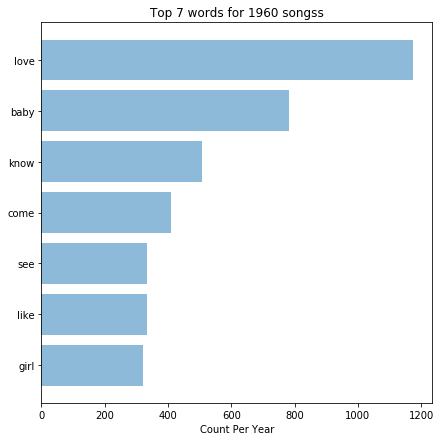

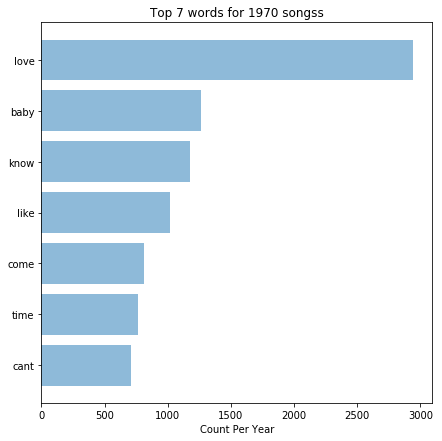

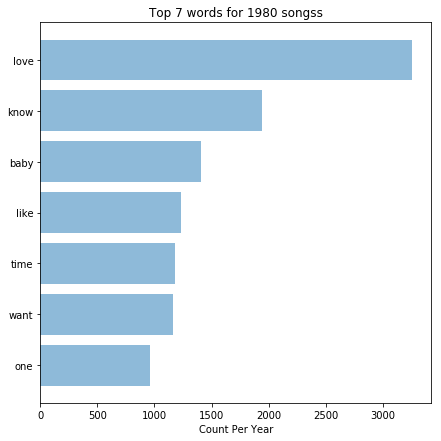

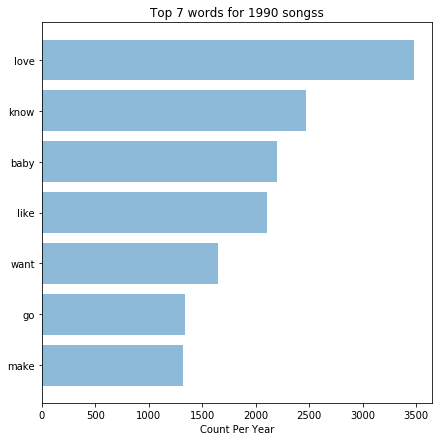

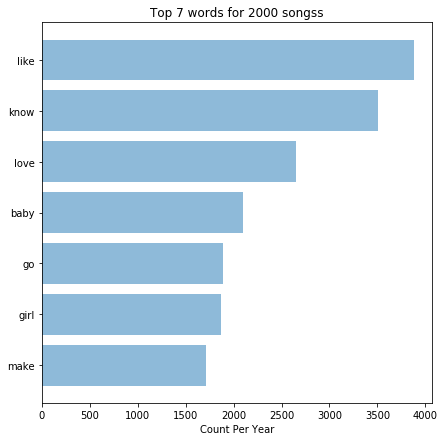

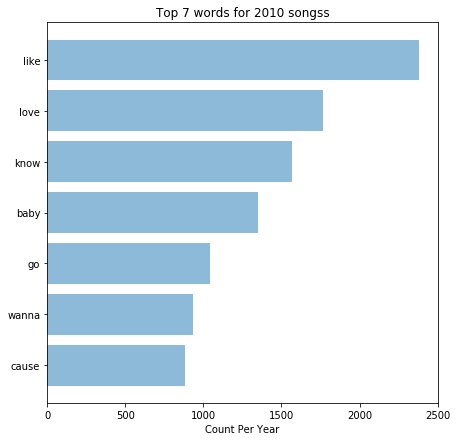

In [12]:
# plot 60s to 2010s --> 
######### CHANGE TOP N SONGS HERE ###########
n=7
word_count_by_decade={}
for i in range(6):
    song = data.loc[data['Year'].between(1960+i*10,1969+i*10,inclusive=True)]
    decade = 1960 + i*10
    count = word_count(song,n,str(decade)+' songs'+'s')
    word_count_by_decade[decade] = count

In [13]:
print(word_count_by_decade)


{1960: [('love', 235.2), ('baby', 156.6), ('know', 101.4), ('come', 81.6), ('see', 66.8), ('like', 66.6), ('girl', 64.4)], 1970: [('love', 294.6), ('baby', 126.6), ('know', 117.3), ('like', 101.9), ('come', 81.5), ('time', 76.4), ('cant', 70.6)], 1980: [('love', 326.2), ('know', 194.2), ('baby', 140.4), ('like', 123.2), ('time', 117.9), ('want', 115.9), ('one', 95.8)], 1990: [('love', 347.9), ('know', 247.4), ('baby', 220.3), ('like', 210.2), ('want', 164.4), ('go', 134.3), ('make', 132.3)], 2000: [('like', 388.0), ('know', 350.2), ('love', 265.6), ('baby', 209.5), ('go', 189.3), ('girl', 187.4), ('make', 171.3)], 2010: [('like', 397.1666666666667), ('love', 294.0), ('know', 261.3333333333333), ('baby', 224.5), ('go', 173.16666666666666), ('wanna', 155.16666666666666), ('cause', 147.5)]}


### Visualizing top N words by decade
Let's use pandas series [line plot function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.line.html) to better visualize the data

<Figure size 2880x2880 with 0 Axes>

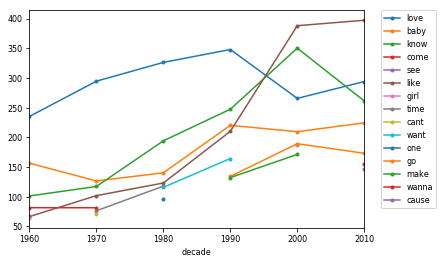

In [14]:
def word_count_to_line_plot(word_count_dict):
    years = word_count_dict.keys()
    df = pd.DataFrame(index=word_count_dict.keys())
    top_words={}
    for year,value in word_count_dict.items():
        value = dict(value)
        for word,count in value.items():
            if word not in top_words.keys():
                top_words[word]=[]
            top_words[word].append((year,count))

    top_words_plots=[]
    for word,series_data in top_words.items():
        df =pd.DataFrame(series_data, columns=['decade', word])
        top_words_plots.append(df)
    top_words_plots_df = reduce(lambda x, y: x.join(y.set_index('decade'), on='decade',how='outer'), top_words_plots).set_index('decade')
    return top_words_plots_df

'''
years = word_count_by_decade.keys()
df = pd.DataFrame(index=word_count_by_decade.keys())
top_words={}
for year,value in word_count_by_decade.items():
    value = dict(value)
    for word,count in value.items():
        if word not in top_words.keys():
            top_words[word]=[]
        top_words[word].append((year,count))

top_words_plots=[]
for word,series_data in top_words.items():
    df =pd.DataFrame(series_data, columns=['decade', word])
    top_words_plots.append(df)
top_words_plots_df = reduce(lambda x, y: x.join(y.set_index('decade'), on='decade',how='outer'), top_words_plots).set_index('decade')
display(top_words_plots_df.head())
'''
df = word_count_to_line_plot(word_count_by_decade)
plt.figure(figsize=(40,40))
#adjust font size
plt.rcParams.update({'font.size': 8})
line= df.plot(style='.-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


## Analyze variance score of songs by decade

We utilize boxplots from matplotlib to boxplots of songs through the decade. pandas boxplot function is biult on [matplotlib boxplot function](https://matplotlib.org/gallery/statistics/boxplot_demo.html)

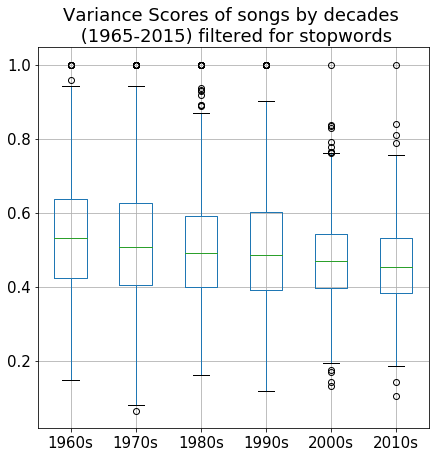

In [15]:
variance_boxplot = {}
for i in range(6):
    variance_scores = data.loc[data['Year'].between(1960+i*10,1969+i*10,inclusive=True)]
    decade = 1960 + i*10
    title = str(decade)+'s'
    variance_boxplot[title] = variance_scores['Variance']
    #display(variance_scores.head())
    
variance_boxplot_df = pd.DataFrame(variance_boxplot)
# adjust size of image
plt.figure(figsize=(7,7))
#adjust font size
plt.rcParams.update({'font.size': 15})
plt.title('Variance Scores of songs by decades \n (1965-2015) filtered for stopwords')
box_plot = variance_boxplot_df.boxplot()

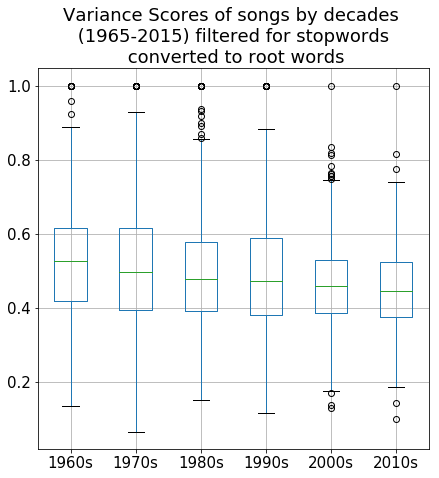

In [16]:
variance_root_boxplot = {}
for i in range(6):
    variance_scores = data.loc[data['Year'].between(1960+i*10,1969+i*10,inclusive=True)]
    decade = 1960 + i*10
    title = str(decade)+'s'
    variance_root_boxplot[title] = variance_scores['Variance Root']
    #display(variance_scores.head())
    
variance_root_boxplot_df = pd.DataFrame(variance_root_boxplot)
# adjust size of image
plt.figure(figsize=(7,7))
#adjust font size
plt.rcParams.update({'font.size': 15})
plt.title('Variance Scores of songs by decades \n (1965-2015) filtered for stopwords \n converted to root words')
box_plot = variance_root_boxplot_df.boxplot()

## Analysis on Beyonce's songs
We see that the top 5 words stay quite constant through the past 50-60 years. So we can conclude that time changes do not affect them let's explore other factors that can affect songs. <br/>
Songs are known as an outlet for an artist's expression of their identity. Perhaps as an artist's views changed their song lyrics did too? Let's take deep dive into Beyonce

In [17]:
for artist in data.Artist.unique():
    if 'beyonce' in artist:
        print (artist)

beyonce featuring jayz
beyonce featuring sean paul
beyonce
beyonce featuring slim thug
beyonce featuring shakira
lady gaga featuring beyonce
beyonce featuring jay z


Nice! We have beyonce songs. Hmmm but the second last one is irrelevant its a lady gaga song featuring beyonce lets' take that out

In [18]:
for artist in data.Artist.unique():
    if re.match(r'^beyonce', artist):
        print(artist)

beyonce featuring jayz
beyonce featuring sean paul
beyonce
beyonce featuring slim thug
beyonce featuring shakira
beyonce featuring jay z


That's better now let's see what beyonce songs we have on our dataset

In [19]:
beyonce= data[data['Artist'].str.match(r'^beyonce')]
print(beyonce.shape)
display(beyonce)

(19, 7)


,Song,Artist,Year,Lyrics,Filtered Lyrics,Variance,Variance Root
3803,crazy in love,beyonce featuring jayz,2003,yes its so crazy right now most incredibly its...,"[yes, crazy, right, incredibly, ya, girl, bee,...",0.424929,0.416431
3811,baby boy,beyonce featuring sean paul,2003,certified quality a dat da girl dem need and d...,"[certified, quality, dat, da, girl, dem, need,...",0.407051,0.391026
3917,naughty girl,beyonce,2004,im feelin sexy i wanna hear you say my name bo...,"[feelin, sexy, wanna, hear, say, name, boy, re...",0.347518,0.340426
3925,me myself and i,beyonce,2004,all the ladies if you feel me help me sing it ...,"[ladies, feel, help, sing, incomprehensible, c...",0.422907,0.400881
3968,baby boy,beyonce featuring sean paul,2004,certified quality a dat da girl dem need and d...,"[certified, quality, dat, da, girl, dem, need,...",0.407051,0.391026
4109,check on it,beyonce featuring slim thug,2006,slim thug you need to stop playing round with ...,"[slim, thug, need, stop, playing, round, clown...",0.524229,0.506608
4174,dej`a vu,beyonce featuring jayz,2006,bassuhhi hatuh808uhjayuh huh ready uh huhlets ...,"[bassuhhi, hatuh808uhjayuh, huh, ready, uh, hu...",0.699507,0.689655
4200,irreplaceable,beyonce,2007,to the left to the left everything you own in ...,"[left, left, everything, box, left, closet, th...",0.394495,0.385321
4261,beautiful liar,beyonce featuring shakira,2007,ay ay nobody likes being played ay oh beyonc...,"[ay, ay, nobody, likes, played, ay, beyoncì£, ...",0.444444,0.438272
4407,single ladies put a ring on it,beyonce,2009,all the single ladies all the single ladies al...,"[single, ladies, single, ladies, single, ladie...",0.424731,0.413978


Hmm there seems to be songs missing here. Crucially her 2016 Lemonade album is missing. This is crucial since we expect her Lemonade album to pay homage to a Black Woman's exprience in America in the wake Black Lives Matter Movement and police brutality.

Anoter [dataset on kaggle](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics) seems more complete. However it is more 'dirty' we'll clean the data up

In [20]:
data2 = pd.read_csv('data/lyrics.csv.zip',index_col='index')
display(data2.head())

,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [21]:
for x in data2.artist.unique():
    if 'beyonce' in x:
        print (x)

beyonce-knowles
beyonce


In [22]:
beyonce= data2[data2['artist'].str.match(r'^beyonce')]
print("Data Shape: ",beyonce.shape)
print("Time Frame: ",np.sort(np.array(beyonce.year.unique())).tolist())
display(beyonce.head())

Data Shape:  (367, 5)
Time Frame:  [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [23]:
# Check if her Lemonade album songs are in
beyonce[beyonce['year']==2016]

,song,year,artist,genre,lyrics
index,,,,,
157,hold-up,2016,beyonce-knowles,Pop,"[Chorus]\nHold up, they don't love you like I ..."
158,lemonade,2016,beyonce-knowles,Pop,NaN
159,daddy-lessons,2016,beyonce-knowles,Pop,"Yee-haw\nOh, oh, oh\nTexas, texas (oh, oh, oh)..."
160,forward,2016,beyonce-knowles,Pop,Forward\nBest foot first just in case\nWhen we...
161,don-t-hurt-yourself,2016,beyonce-knowles,Pop,[Intro: BeyoncÃ©]\nOh la la la\nOh la la la\nO...
162,formation,2016,beyonce-knowles,Pop,What happened at the New Wil'ins?\nBitch I'm b...
163,all-night,2016,beyonce-knowles,Pop,Found the truth beneath your lies\nAnd true lo...
164,sorry,2016,beyonce-knowles,Pop,"Sorry, I ain't sorry\nSorry, I ain't sorry\nI ..."
165,sandcastles,2016,beyonce-knowles,Pop,[Verse]\nWe built sandcastles that washed away...


Everythin seems in order let's clean up the data now <br/>

Metro lyrics also likes to add the singers name/intro/verse insquare brackets $[ ]$ so well remove square brakcets and anything in them

In [24]:
# drop na
beyonce = beyonce.dropna()
# remove quare brackets and anything in the,
beyonce['lyrics'] = beyonce['lyrics'].apply(lambda x:re.sub("[\[].*[\]]","",x))
# strip whitespace and remove punctuation
beyonce['lyrics'] = beyonce.lyrics.str.replace(r'[^\w\s]|^\s+|\s+$', '')
#remove new line characters
beyonce['lyrics'] = beyonce.lyrics.str.replace(r'\n',' ')
# replace empty string with NaN (so can drop easily)
beyonce = beyonce.replace({'': np.nan})
# lower all characters
beyonce.lyrics = beyonce.lyrics.str.lower()
print("after processing, data: ",beyonce.shape)
display(beyonce.head())

after processing, data:  (360, 5)


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know im gonna cut ri...
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy its like you seem so...
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isnt hard to f...
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book about...
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party its popp...


In [25]:
# filter out stopwords
beyonce['Filtered Lyrics']=beyonce['lyrics'].apply(lambda x:[word for word in x.split() if word not in stopwords])
# calculate variance of song
beyonce['Variance'] = beyonce['Filtered Lyrics'].apply(lambda x: np.unique(np.array(x)).shape[0]/len(x))
# change all words to root word
beyonce['Variance Root'] = beyonce['Filtered Lyrics'].apply(lambda x:[stem(word) for word in x])
beyonce['Variance Root'] = beyonce['Variance Root'].apply(lambda x: np.unique(np.array(x)).shape[0]/len(x))
#rename
beyonce =  beyonce.rename(index=str, columns={'song':'Song','year':'Year','artist':'Artist','lyrics':'Lyrics'})
display(beyonce.head())

,Song,Year,Artist,genre,Lyrics,Filtered Lyrics,Variance,Variance Root
index,,,,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know im gonna cut ri...,"[baby, know, cut, right, chase, women, made, l...",0.480663,0.475138
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy its like you seem so...,"[playin, everything, easy, like, seem, sure, s...",0.639640,0.576577
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isnt hard to f...,"[search, tenderness, isnt, hard, find, love, n...",0.819444,0.805556
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book about...,"[wrote, book, stand, title, book, would, life,...",0.356808,0.347418
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party its popp...,"[party, people, people, party, popping, sittin...",0.157233,0.144654


In [26]:
np.sort(beyonce.Year.unique()).tolist()

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

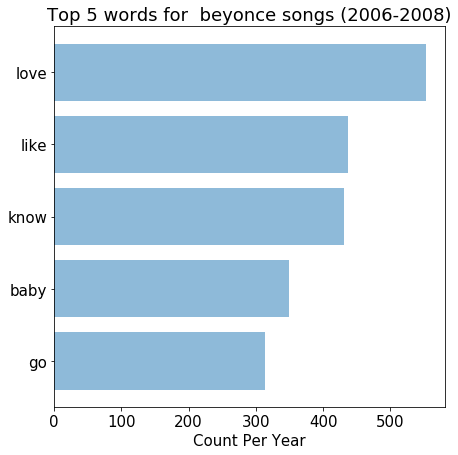

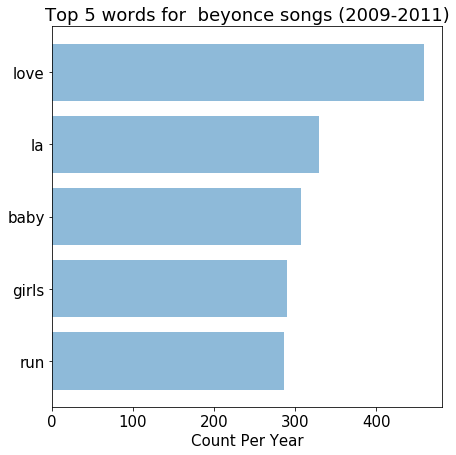

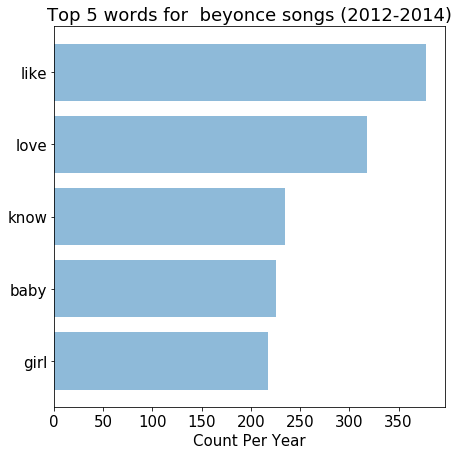

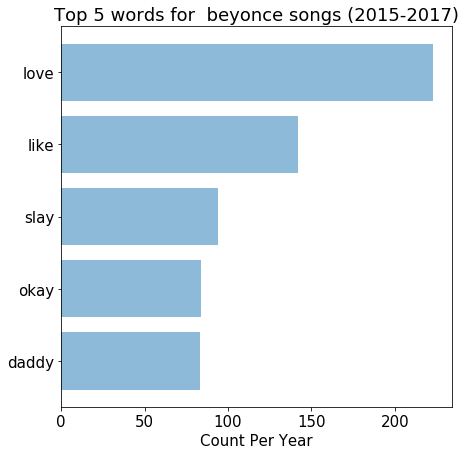

In [27]:
#analyze word count in beynoce songs for 3 year intervals
n=5
beyonce_word_count={}
for i in range(4):
    song = beyonce.loc[beyonce['Year'].between(2006+i*3,2008+i*3,inclusive=True)]
    year=str(2006+i*3)+'-'+str(2008+i*3)
    count = word_count(song,n,' beyonce songs ('+year+')')
    beyonce_word_count[year] = count

,love,like,know,baby,go,la,girls,run,girl,slay,okay,daddy
decade,,,,,,,,,,,,
2006-2008,184.333333,145.666667,143.666667,116.333333,104.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-2011,152.666667,NaN,NaN,102.333333,NaN,109.666667,96.666667,95.333333,NaN,NaN,NaN,NaN
2012-2014,106.000000,126.000000,78.333333,75.333333,NaN,NaN,NaN,NaN,72.333333,NaN,NaN,NaN
2015-2017,111.500000,71.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,42.0,41.5


<Figure size 2880x2880 with 0 Axes>

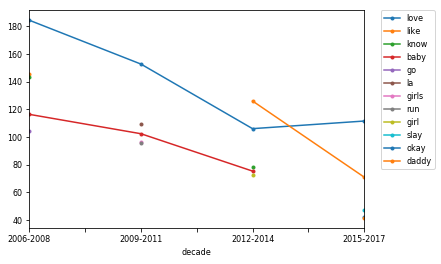

In [28]:
df = word_count_to_line_plot(beyonce_word_count)
display(df)
plt.figure(figsize=(40,40))
#adjust font size
plt.rcParams.update({'font.size': 8})
line= df.plot(style='.-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


### Year by Year analysis may be more appropirate

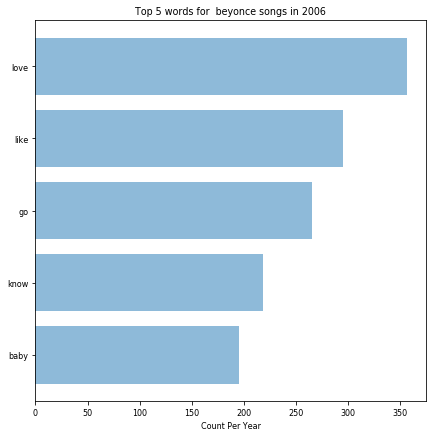

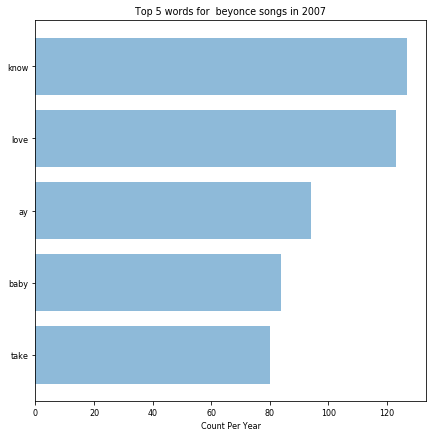

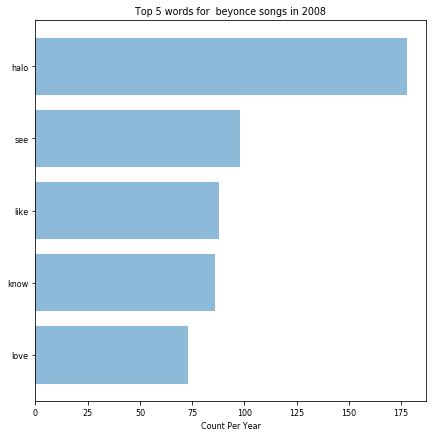

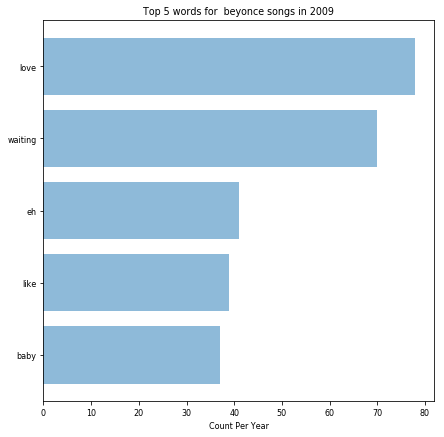

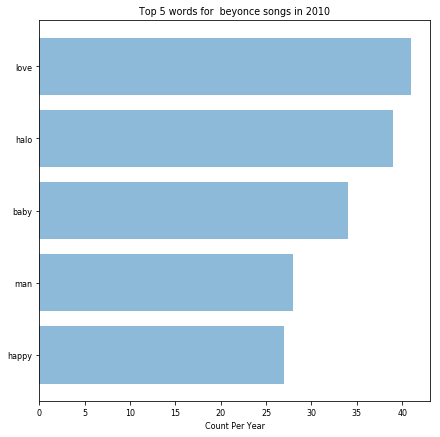

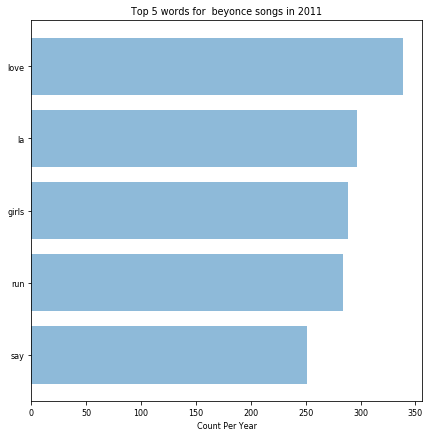

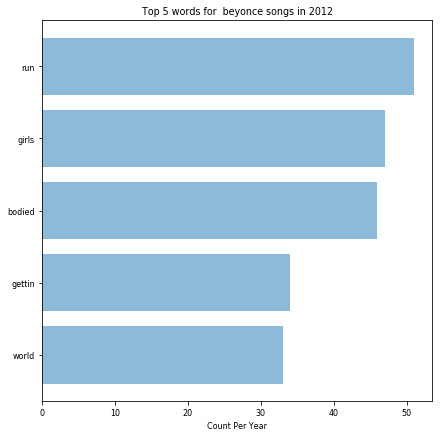

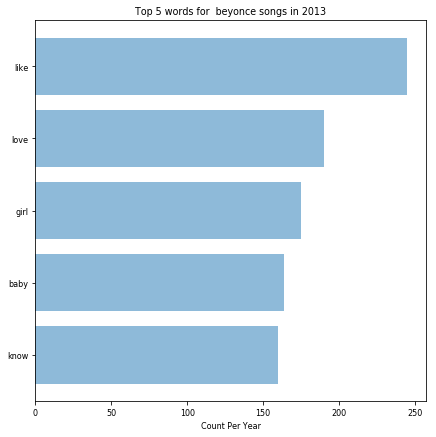

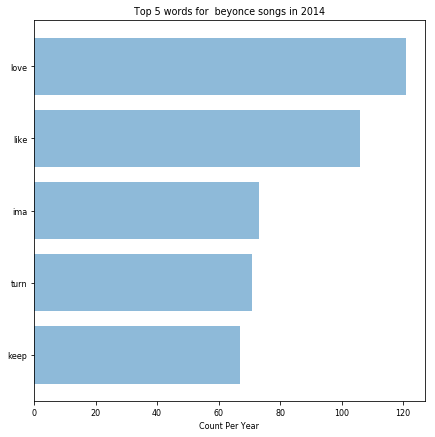

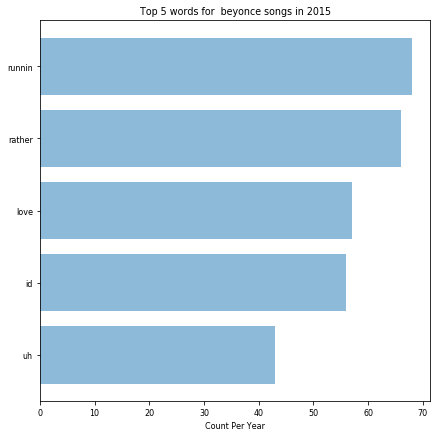

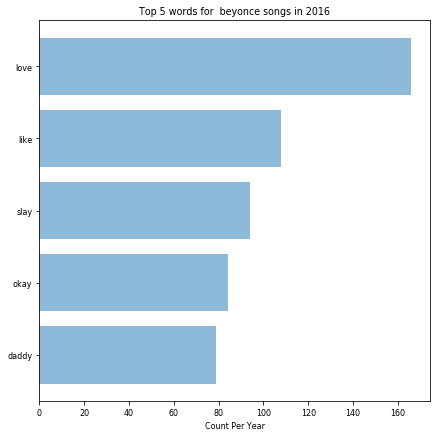

In [29]:
n=5
beyonce_yearly_word_count={}
for i in range(len(np.sort(beyonce.Year.unique()).tolist())):
    year = 2006+i
    song = beyonce.loc[beyonce['Year']==year]
    count = word_count(song,n,' beyonce songs in '+str(year))
    beyonce_yearly_word_count[year] = count

,love,like,go,know,baby,ay,take,halo,see,waiting,...,ima,turn,keep,runnin,rather,id,uh,slay,okay,daddy
decade,,,,,,,,,,,,,,,,,,,,,
2006,357.0,295.0,265.0,218.0,195.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,123.0,NaN,NaN,127.0,84.0,94.0,80.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,73.0,88.0,NaN,86.0,NaN,NaN,NaN,178.0,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,78.0,39.0,NaN,NaN,37.0,NaN,NaN,NaN,NaN,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,41.0,NaN,NaN,NaN,34.0,NaN,NaN,39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,190.0,245.0,NaN,160.0,164.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,121.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.0,71.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,68.0,66.0,56.0,43.0,NaN,NaN,NaN


<Figure size 2880x2880 with 0 Axes>

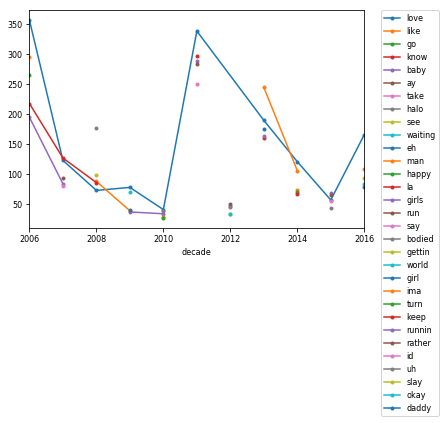

In [30]:
df = word_count_to_line_plot(beyonce_yearly_word_count)
display(df)
plt.figure(figsize=(40,40))
#adjust font size
plt.rcParams.update({'font.size': 8})
line= df.plot(style='.-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [31]:
beyonce.rename(index=str,columns={'song':'Song'})

,Song,Year,Artist,genre,Lyrics,Filtered Lyrics,Variance,Variance Root
index,,,,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know im gonna cut ri...,"[baby, know, cut, right, chase, women, made, l...",0.480663,0.475138
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy its like you seem so...,"[playin, everything, easy, like, seem, sure, s...",0.639640,0.576577
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isnt hard to f...,"[search, tenderness, isnt, hard, find, love, n...",0.819444,0.805556
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book about...,"[wrote, book, stand, title, book, would, life,...",0.356808,0.347418
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party its popp...,"[party, people, people, party, popping, sittin...",0.157233,0.144654
5,all-i-could-do-was-cry,2009,beyonce-knowles,Pop,i heard church bells ringing i heard a choir s...,"[heard, church, bells, ringing, heard, choir, ...",0.650000,0.633333
6,once-in-a-lifetime,2009,beyonce-knowles,Pop,this is just another day that i would spend wa...,"[another, day, would, spend, waitin, right, on...",0.473684,0.473684
7,waiting,2009,beyonce-knowles,Pop,waiting waiting waiting waiting waiting waitin...,"[waiting, waiting, waiting, waiting, waiting, ...",0.308824,0.284314
8,slow-love,2009,beyonce-knowles,Pop,i read all of the magazines while waiting arou...,"[read, magazines, waiting, around, said, could...",0.358407,0.353982


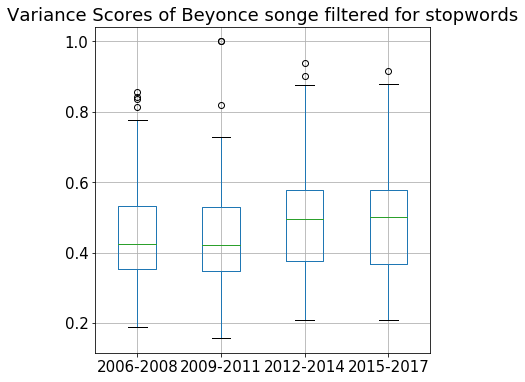

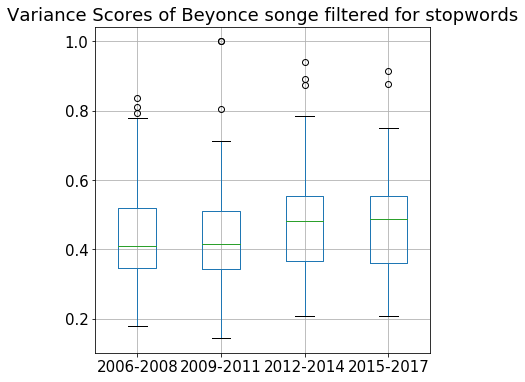

In [46]:
variance_boxplot = {}
variance_root_boxplot = {}

for i in range(4):
    variance_scores = beyonce.loc[beyonce['Year'].between(2006+i*3,2008+i*3,inclusive=True)]
    year=str(2006+i*3)+'-'+str(2008+i*3)
    variance_boxplot[year]=variance_scores['Variance']
    variance_root_boxplot[year] = variance_scores['Variance Root']

variance_boxplot_df = pd.DataFrame(variance_boxplot)
variance_root_boxplot_df = pd.DataFrame(variance_root_boxplot)

# adjust size of image
plt.figure(figsize=(6,6))
#adjust font size
plt.rcParams.update({'font.size': 15})
plt.title('Variance Scores of Beyonce songe filtered for stopwords')
variance_boxplot_df.boxplot()
plt.show()
plt.figure(figsize=(6,6))

plt.rcParams.update({'font.size': 15})
plt.title('Variance Scores of Beyonce songe filtered for stopwords')
variance_root_boxplot_df.boxplot()
plt.show()


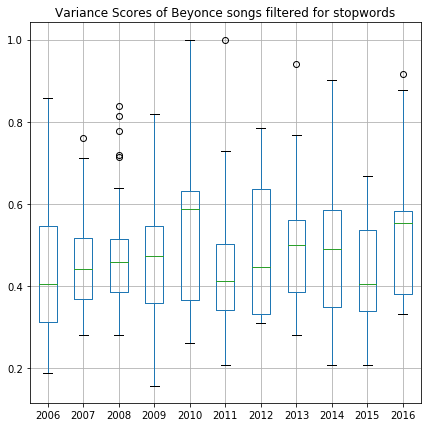

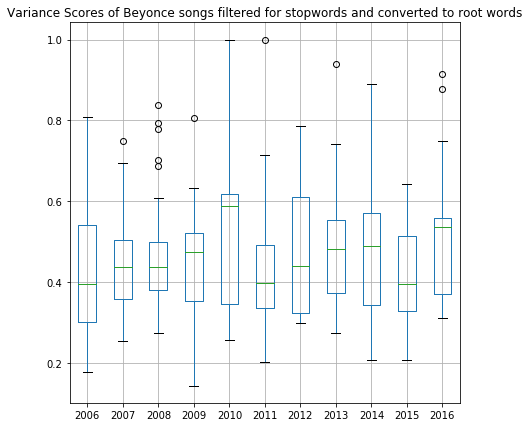

In [47]:
variance_boxplot = {}
variance_root_boxplot = {}

for i in range(len(np.sort(beyonce.Year.unique()).tolist())):
    year = 2006+i
    variance_scores = beyonce.loc[beyonce['Year']==year]
    variance_boxplot[year] = variance_scores['Variance']
    variance_root_boxplot[year] = variance_scores['Variance Root']

variance_boxplot_df = pd.DataFrame(variance_boxplot)
variance_root_boxplot_df = pd.DataFrame(variance_root_boxplot)

# adjust size of image
plt.figure(figsize=(7,7))
#adjust font size
plt.rcParams.update({'font.size': 10})
plt.title('Variance Scores of Beyonce songs filtered for stopwords')
variance_boxplot_df.boxplot()
plt.show()

plt.figure(figsize=(7,7))
#adjust font size
plt.rcParams.update({'font.size': 10})
plt.title('Variance Scores of Beyonce songs filtered for stopwords and converted to root words')
variance_root_boxplot_df.boxplot()
plt.show()
